### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework. 

### Imran Zamin Ali

### Initial Setup

In [ ]:
import pandas as pd
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
import statsmodels
from BSE import market_session


# given a tuple of the algos, a tuple of the percentages for that trader and the number of traders return the specs
def get_traders_specs(algos, percentages, num_traders):
    if sum(percentages) != 100:
        raise Exception('The percentages should add to 100')
    if len(algos) != len(percentages):
        raise Exception(f'algos len: {len(algos)} %s len: {len(percentages)} are not equal')
    
    num_traders_each = tuple(round(percent * num_traders / 100) for percent in percentages)
    if sum(num_traders_each) != num_traders:
        raise Exception('num traders each != num traders')
    return list(zip(algos, num_traders_each))

def run_stat_tests(profits):
    print('Check each column if the data is normally distrubuted with the shapiro wilk test:')
    is_normal = True
    # check if the data is normally distributed
    for col in profits.columns:
        _, pvalue = stats.shapiro(profits[col])
        if pvalue < 0.05:
            print(f'Condition: {col}. Reject null hypothesis (p={pvalue}). There is enough evidence to suggest the data is not normally distributed')
            is_normal = False
        else:
            print(f'Condition: {col}. Do not reject null hypothesis (p={pvalue}). There is not enough evidence to suggest the data is not normally distributed')
            
    columns = [profits[column] for column in profits.columns]
    is_two_dist = len(columns) == 2
    if is_two_dist:
        fig, axes = plt.subplots(1,2)
        sns.kdeplot(data=profits, fill=False, ax=axes[0])
        sns.boxplot(data=profits, ax=axes[1])
    else:
        sns.violinplot(data=profits, inner='box')
    pvalue = None
    if is_normal:
        test_name = 'paired t-test' if is_two_dist else 'ANOVA test'
        _, pvalue = stats.ttest_rel(*columns) if is_two_dist else stats.f_oneway(*columns)
    else:
        test_name = 'Wilcoxon Signed Rank test' if is_two_dist else 'Friedman test'
        _, pvalue = stats.wilcoxon(*columns) if is_two_dist else stats.friedmanchisquare(*columns)
    
    print(f'There are {len(columns)} distributions. Therefore using {test_name}')
    if pvalue < 0.05:
        print(f'Reject null hypothesis (p={pvalue}). There is sufficient evidence to suggest groups have a population different mean')
    else:
        print(f'Do not reject null hypothesis (p={pvalue}). There is not enough evidence to suggest the groups have a different population mean')
            
# run n instances of market session. Collect the final profits for each trader for each session and store in a numpy array. Apply the appropriate hypothesis test
def run_experiment(n, market_args, initial_seed):
    # create an empty dataframe
    # traders = market_args[3]
    # buyers = traders['buyers']
    # sellers = traders['sellers']
    # algo_names = list({algo for (algo, _) in buyers+sellers})
    # profits = pd.DataFrame(columns=algo_names)
    profits = pd.DataFrame()
    
    print(f'n: {n}')
    for i in range(n):
        random.seed(initial_seed + i)
        market_session(*market_args)
        trial_id = market_args[0]
        filename = f'{trial_id}_avg_balance.csv'
        file = open(filename, 'r')
        final_entry = (file.readlines()[-1]).split(',')
        #print(len(final_entry))
        #print(final_entry)
        file.close()
        os.remove(filename)
        profit_entry = {}
        for j in range(4, len(final_entry)-4, 4):
            col_name = final_entry[j]
            #print(col_name)
            col_val = final_entry[j+3]
            #print(col_val)
            profit_entry[col_name] = round(float(col_val.strip()))
            
        #print(profit_entry)
        entry_df = pd.DataFrame([profit_entry])
        #profits = profits.append(profit_entry, ignore_index=True)
        profits = pd.concat([profits, entry_df], ignore_index=True)
    
    run_stat_tests(profits)
            
    

### Part A

In [31]:
sup_range = (310, 310)
dem_range = (250, 490)
num_buyers = 20
num_sellers = 20
r = 50
r_vals = (r, 100 - r)
algos = ('SHVR', 'ZIC')
seller_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_sellers)
buyer_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_buyers)
traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}

#plot_sup_dem(num_buyers, [sup_range], num_sellers, [dem_range], 'fixed')



In [33]:
start_time = 0
end_time = 5 * 60 * 60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]
order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
              'interval': order_interval, 'timemode': 'periodic'}
verbose = False
dump_flags = {'dump_blotters': True, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': False}

In [34]:
# for i in tqdm(range(n)):
#     random.seed(100) # changing the seed value will give us different seqences of random numbers
#     trial_id = 'smith_chart_'
#     market_session(trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose)
trial_id = 'smith_chart'
initial_seed = 100
run_experiment(1, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)

# TODO create a for loop that runs to n. Changes the seed each time as well as the trial id. Dumps the avgbals. Take the total profits for each trader type from the last line of the csv file and puts it into a dataframe

# 

n: 1


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'smith_chart_avg_balance.csv'

n: 500
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition:  SHVR. Do not reject null hypothesis (p=0.38939961791038513). There is not enough evidence to suggest the data is not normally distributed
Condition:  ZIC. Do not reject null hypothesis (p=0.256633996963501). There is not enough evidence to suggest the data is not normally distributed
There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.3170595362639759). There is not enough evidence to suggest the groups have a different population mean


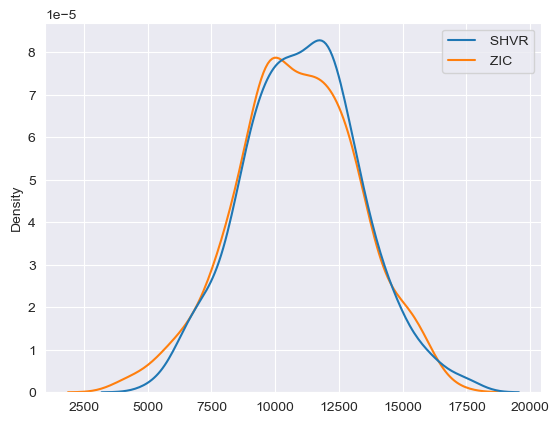

In [20]:
run_experiment(500, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)

### Part B

In [6]:
def part_b():
    n_values = [50, 500]
    for n in n_values:
        r_list = list(range(10, 91, 10))
        for r in r_list:
            r_vals = (r, 100-r)
            seller_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_sellers)
            buyer_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_buyers)
            traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
            print(f'R: {r}')
            run_experiment(n, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)
        
            print('-----------------------------------------------------------------------------------------------------')

part_b()

  0%|          | 0/9 [00:00<?, ?it/s]

R: 10
n: 50


 11%|█         | 1/9 [00:30<04:02, 30.27s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.
Condition  ZIC. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.
There are 2 distributions. Therefore using Mann-Whitney
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 20
n: 50


 22%|██▏       | 2/9 [01:00<03:30, 30.14s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.39). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.54). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 30
n: 50


 33%|███▎      | 3/9 [01:30<03:01, 30.21s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.75). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.68). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 40
n: 50


 44%|████▍     | 4/9 [02:01<02:32, 30.51s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.15). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.52). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 50
n: 50


 56%|█████▌    | 5/9 [02:31<02:01, 30.46s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.69). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.52). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Do not reject null hypotheiss. There is not enough evidence to suggest the groups have a different population mean
R: 60
n: 50


 67%|██████▋   | 6/9 [03:01<01:30, 30.14s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.26). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.22). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 70
n: 50


 78%|███████▊  | 7/9 [03:30<00:59, 29.86s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.19). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.30). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 80
n: 50


 89%|████████▉ | 8/9 [04:01<00:29, 29.98s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.45). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.62). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 90
n: 50


100%|██████████| 9/9 [04:32<00:00, 30.33s/it]


Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.34). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.12). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
-----------------------------------------------------------------------------------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

R: 10
n: 500


 11%|█         | 1/9 [04:52<38:59, 292.43s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
Condition  ZIC. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
There are 2 distributions. Therefore using Mann-Whitney
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 20
n: 500


 22%|██▏       | 2/9 [09:49<34:25, 295.11s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
Condition  ZIC. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
There are 2 distributions. Therefore using Mann-Whitney
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 30
n: 500


 33%|███▎      | 3/9 [14:50<29:46, 297.80s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.30). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.30). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 40
n: 500


 44%|████▍     | 4/9 [19:48<24:49, 297.90s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.12). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.29). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 50
n: 500


 56%|█████▌    | 5/9 [24:52<20:01, 300.26s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.41). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.28). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Do not reject null hypotheiss. There is not enough evidence to suggest the groups have a different population mean
R: 60
n: 500


 67%|██████▋   | 6/9 [29:53<15:01, 300.47s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.29). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.30). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 70
n: 500


 78%|███████▊  | 7/9 [35:01<10:05, 302.77s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.51). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.43). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 80
n: 500


 89%|████████▉ | 8/9 [40:11<05:05, 305.18s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We cannot reject the null hypothesis (p=0.20). Therefore, data is normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.27). Therefore, data is normally distributed.
There are 2 distributions. Therefore using t-test
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
R: 90
n: 500


100%|██████████| 9/9 [46:06<00:00, 307.44s/it]

Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  SHVR. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
Condition  ZIC. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
There are 2 distributions. Therefore using Mann-Whitney
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
-----------------------------------------------------------------------------------------------------


### Part C

In [16]:
def part_c():
    algos = ('SHVR', 'GVWY', 'ZIC', 'ZIP')
    ratios_list = [[25, 25, 25, 25], [40,20,20,20], [10,30,30,30], [70,10,10,10]]
    n_vals = [50, 500]
    for n in n_vals:
        for i in range(len(ratios_list)):
            for j in range(len(ratios_list[i])):
                seller_specs = get_traders_specs(algos=algos, percentages=tuple(ratios_list[i]), num_traders=num_sellers)
                buyer_specs = get_traders_specs(algos=algos, percentages=tuple(ratios_list[i]), num_traders=num_sellers)
                traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
                order_sched = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'periodic'}
                print(seller_specs)
                run_experiment(n, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)
                print('-----------------------------------------------------------------------------------------------------')
                if len(set(ratios_list[i])) == 1: # no need to permute if all elements are equal
                    break
                ratios_list[i].append(ratios_list[i].pop(0)) # rotates by 1  

In [17]:
part_c()

[('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
n: 50
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  GVWY. We cannot reject the null hypothesis (p=0.52). Therefore, data is normally distributed.
Condition  SHVR. We can reject the null hypothesis (p=0.01). Therefore, data is not normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.48). Therefore, data is normally distributed.
Condition  ZIP. We cannot reject the null hypothesis (p=0.18). Therefore, data is normally distributed.
There are 4 distributions. Therefore using Kruskal-Wallis
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
-----------------------------------------------------------------------------------------------------
[('SHVR', 8), ('GVWY', 4), ('ZIC', 4), ('ZIP', 4)]
n: 50
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  GVWY. We cannot reject the n

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT. 

In [7]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

C:\Users\izami\AppData\Local\Temp\ipykernel_39204\2932030967.py:3: DeprecationWarning: nbformat.current is deprecated since before nbformat 3.0

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  from nbformat import current


In [8]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "cw.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 12. Limit is 2000 words.
